In [103]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import bomeba0 as bmb
from numba import jit
from numpy import linalg as LA

In [2]:
n = 20
prot = bmb.Protein('A' * n)
#ang = np.random.uniform(-180, 180, size=(n, 2))
#for i in range(0, len(prot)):
#    phi, psi = ang[i]
#    prot.set_phi(i, phi)
#    prot.set_psi(i, psi)

def fragments(prot):
    """
    Takes a Protein object and returns a list.
    of it's fragmented coordinates.
    ----------------
    Parameters
    ----------------
    prot: Protein object
    
    -----------------
    Returns
    -----------------
    selec: List of selected coordinates.
    """
    xyz = prot.coords
    boxes = bmb.OBB._little_boxes(prot)
    selec =  [xyz.take(i, 0) for i in  boxes]
    return selec

selec = fragments(prot)
frag = np.concatenate(selec)

* Intenté acelerar np.dot(), pero solo logré igualar la velocidad de numpy!
* Al parecer es posible usarla descomposición QR en vez de los autovalores (esto hay que evaluarlo)
* De forma llamativa np.linalg.qr como np.linalg.eigh se pueden acelerar con numba. 

In [3]:
@jit()
def eigh(A):
    return np.linalg.eigh(A)[1]

# https://github.com/danbar/qr_decomposition
@jit
def qr(cov):
    return np.linalg.qr(cov)[0]

@jit
def mini(xyz):
    return np.min(xyz[:,0]), np.min(xyz[:,1]), np.min(xyz[:,2])

@jit
def maxi(xyz):
    return np.max(xyz[:,0]), np.max(xyz[:,1]), np.max(xyz[:,2])

In [4]:
class Node:    
    
    """Constructor to create a new node"""
    
    def __init__(self, coord, parents, children):
        self.obb = vertex_OBB(coord)
        self.parents = parents
        self.children = children
        
    def __str__(self):
        return '{}'.format(self.obb, self.parents, self.children)
    
    def get_dot(self, index):
        """
        Gets the coodinates of a dot given an index for it as in:
        https://cdn.tutsplus.com/gamedev/uploads/legacy/008_separatingAxisTheorem/assets/conventions.jpg        
        """
        if index == 0:
            return np.array([np.average(self.obb[0][:,0]),
                            np.average(self.obb[0][:,1]),
                            np.average(self.obb[0][:,2])])
        else:
            return self.obb[0][index-1,:]

def vertex_OBB(XYZ):
        """
        Computes the 8 vertex of the Oriented Bounding Box

        Parameters:
        -----------
        XYZ : array of shape (n,3).
            Contains the coordinates of the atoms to be enclosed by the OBB.  
              

        Returns:
        -----------
        vertex : OBB coordinates
        eigen_vecs : transformation matrix
        vertex_no : XYZ
        """
        # Compute scatter matrix
        scat = np.dot(XYZ.T, XYZ)
        # Compute qr decomposition
        eigen_vecs = qr(scat)
        # Compute eigenvalues
        #eigen_vecs = eigh(scat)
        # project XY onto the "principal axes"
        XYZ_proj = np.dot(XYZ, eigen_vecs)
        # compute min/max values
        min_x, min_y, min_z = mini(XYZ_proj)
        max_x, max_y, max_z = maxi(XYZ_proj)

        Sr = 1.80 #S radius
        min_x, min_y, min_z = min_x - Sr, min_y - Sr, min_z - Sr
        max_x, max_y, max_z = max_x + Sr, max_y + Sr, max_z + Sr
        
        ver_proj_S = np.array([[max_x, max_y, max_z],
                               [max_x, min_y, max_z],
                               [min_x, min_y, max_z],
                               [min_x, max_y, max_z],
                               [max_x, max_y, min_z],
                               [max_x, min_y, min_z],
                               [min_x, min_y, min_z],
                               [min_x, max_y, min_z]])

        # project min/max values back to the original system
        vertex_proj = np.dot(ver_proj_S, eigen_vecs.T)
        #vertex_no = ver_proj @ eigen_vecs.T
        return vertex_proj, eigen_vecs, XYZ

def dimensions(node):
    """
    Computes width, height and depth of an OBB,
    contained in a node object.
    
    ----------------
    Parameters:
    ----------------
    node: node object
    """
    width = np.max(node.obb[0][:,0]) - np.min(node.obb[0][:,0])
    height = np.max(node.obb[0][:,1]) - np.min(node.obb[0][:,1])
    depth = np.max(node.obb[0][:,2]) - np.min(node.obb[0][:,2])
    return [width, height, depth]

def create_nodes(selec):
        """
        Creates every node

        Parameters:
        -----------
        selec : list of arrays containing selection coordinates
        
        Returns:
        -----------
        nodes: (list of lists)
            every level in the hierarchy and every node in each level
        """
        lower_layer = [Node(i, parents=1, children=0) for i in selec]

        combined = combine(lower_layer)
        
        nodes = [lower_layer]

        for _ in selec:
            layer = []
            for node_list in combined:
                if len(node_list) == 1:
                    layer.append(node_list[0])
                else:
                    c = np.concatenate((node_list[0].obb[2], node_list[1].obb[2]))
                    layer.append(Node(c, parents = 1, children = 2))

            combined = combine(layer)
            nodes.append(layer)
            if len(combined[0]) == 1:
                break
        return nodes


def combine(layer):
    """
    group nodes in layer two by two.
    If nodes are odd, the last node will be unpaired.

    Parameters:
    -----------
    layer : list
        list of nodes
    """
    return [layer[n:n+2] for n in range(0, len(layer), 2)]

In [5]:
nodes = create_nodes(selec)

In [6]:
nodes[0][5].get_dot(1)

array([-51.69704882, -29.90324747,   2.03042265])

In [7]:
%timeit create_nodes(selec)
%timeit prot.energy()

100 loops, best of 3: 3.52 ms per loop
The slowest run took 54.51 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 3.58 ms per loop


<IPython.core.display.Javascript object>


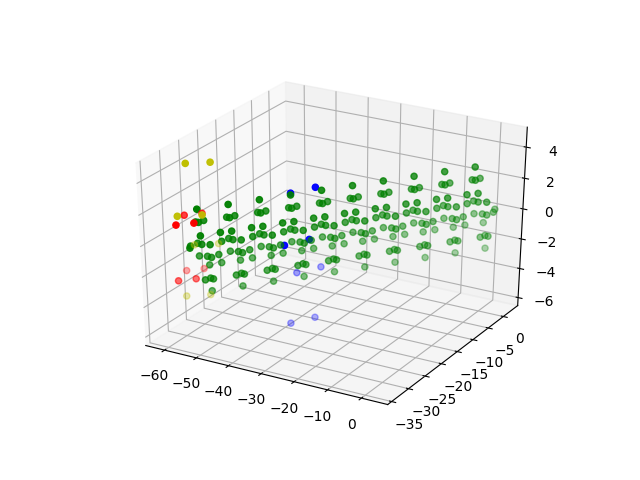

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(frag[:,0], frag[:,1], frag[:,2], c='g')
#ax.scatter( 0.39791296,  2.33033074,  0.9413822)
#ax.scatter(q[:,0], q[:,1], q[:,2], c='m')

lv1 = 0
lv2 = -2
bx = 0
ax.scatter(nodes[lv1][0].obb[0][:,0],  nodes[lv1][0].obb[0][:,1], nodes[lv1][0].obb[0][:,2], c ='r')#
ax.scatter(nodes[lv1][15].obb[0][:,0],  nodes[lv1][15].obb[0][:,1], nodes[lv1][15].obb[0][:,2], c ='b')#
ax.scatter(nodes[lv1][1].obb[0][:,0],  nodes[lv1][1].obb[0][:,1], nodes[lv1][1].obb[0][:,2], c ='y')#

#### box for whole protein is the same than the one computed bottom-up
box = vertex_OBB(frag)[0]
#ax.scatter(box[:,0] , box[:,1] , box[:,2], c='b')

In [9]:
def collide(hierarchy, level, a , b):
    """
    Determines if two nodes collide.
    
    -----------------
    Parameters:
    -----------------
    
    hierarchy: output of create_nodes function. List of lists
    level: int. Level in the hierarchy.
    a, b: int. Index of the nodes in  a level.
    """
    
    axis = (np.any(np.absolute(hierarchy[level][a].obb[0][:,0]-hierarchy[level][b].obb[0][:,0]) * 2 < (dimensions(hierarchy[level][a])[0] + dimensions(hierarchy[level][b])[0])),
            np.any(np.absolute(hierarchy[level][a].obb[0][:,1]-hierarchy[level][b].obb[0][:,1]) * 2 < (dimensions(hierarchy[level][a])[1] + dimensions(hierarchy[level][b])[1])),
            np.any(np.absolute(hierarchy[level][a].obb[0][:,2]-hierarchy[level][b].obb[0][:,2]) * 2 < (dimensions(hierarchy[level][a])[2] + dimensions(hierarchy[level][b])[2])))
    return np.any(axis)

In [10]:
def DoBoxesIntersect(BVH):
    """
    Read a BVH from the top to the bottom,
    and detect colliding nodes. 
    
    -----------------
    Parameters:
    -----------------
    BVH: list of lists. Output of create nodes function. 
    """
    algo = [] 
    for level in range(2, len(BVH)):
        for node in range(0, len(BVH[-level]) - 1):
            for neighbour in range(node, len(BVH[-level])):
                algo.append(collide (BVH, -level, node, neighbour))
    return algo

In [11]:
#DoBoxesIntersect(nodes)

In [12]:
length = nodes[0][0].obb[0][:,0] - nodes[0][1].obb[0][:,0]
half_width_box1 = dimensions(nodes[-2][0])[0] * 0.5
half_width_box2 = dimensions(nodes[-2][1])[0] * 0.5

gap_between_boxes = length - half_width_box1 - half_width_box2

if np.any(gap_between_boxes) > 0 : print('its a big gap')
elif np.any(gap_between_boxes) == 0 : print('theyre touching')
elif np.any(gap_between_boxes) < 0 : print('theyre penetrating')

its a big gap


In [98]:
#box1
box1 = nodes[0][0]
# box2
box2 = nodes[0][1]
# var dot10:Point = box1.getDot(0);
dot10 = box1.get_dot(0)
# var dot11:Point = box1.getDot(1);
dot11 = box1.get_dot(1)
 
# var dot20:Point = box2.getDot(0);
dot20 = box2.get_dot(0)
# var dot24:Point = box2.getDot(4);
dot24 = box2.get_dot(4)

# //Actual calculations
# var axis:Vector2d = new Vector2d(1, -1).unitVector;
axis = np.array([1, -1, 1]) # ???
# var C:Vector2d = new Vector2d(
#     dot20.x - dot10.x,
#     dot20.y - dot10.y
# )
C = np.array([dot20[0] - dot10[0], dot20[1] - dot10[1], dot20[2] - dot10[2]])
# var A:Vector2d = new Vector2d(
#     dot11.x - dot10.x,
#     dot11.y - dot10.y
# )
A = np.array([dot11[0] - dot10[0], dot11[1] - dot10[1], dot11[2] - dot10[2]])

# var B:Vector2d = new Vector2d(
#     dot24.x - dot20.x,
#     dot24.y - dot20.y
# )
B = np.array([dot24[0] - dot20[0], dot24[1] - dot20[1], dot24[2] - dot20[2]])

# var projC:Number = C.dotProduct(axis)
projC = np.dot(C, axis)
# var projA:Number = A.dotProduct(axis);
projA = np.dot(A, axis)
# var projB:Number = B.dotProduct(axis);
projB = np.dot(B, axis)
 
# var gap:Number = projC - projA + projB; //projB is expected to be a negative value
gap = projC - projA + projB

# if (gap > 0) t.text = "There's a gap between both boxes"
if gap > 0 :print("There's a gap between the boxes", gap)
# else if (gap > 0) t.text = "Boxes are touching each other"
elif gap == 0: print("Boxes are touching each other")
# else t.text = "Penetration had happened."
elif gap < 0: print("Penetration had happened.", gap)

There's a gap between the boxes 2.38598184216


In [101]:
# //preparing the vectors from origin to points
# //since origin is (0,0), we can conveniently take the coordinates 
# //to form vectors
# var axis:Vector2d = new Vector2d(1, -1).unitVector;
# var vecs_box1:Vector.<Vector2d> = new Vector.<Vector2d>;
# var vecs_box2:Vector.<Vector2d> = new Vector.<Vector2d>;
# for (var i:int = 0; i < 5; i++) {
#var corner_box1:Point = box1.getDot(i)
#     var corner_box2:Point = box2.getDot(i)
#     vecs_box1.push(new Vector2d(corner_box1.x, corner_box1.y));
#     vecs_box2.push(new Vector2d(corner_box2.x, corner_box2.y));
vecs_box1 = []
vecs_box2 = []
for i in range(0, 9):
    corner_box1 = box1.get_dot(i)
    corner_box2 = box2.get_dot(i)
    vecs_box1.append([corner_box1[0], corner_box1[1], corner_box1[2]])
    vecs_box2.append([corner_box2[0], corner_box2[1], corner_box2[2]])


vecs_box1_ = box1.obb[0]
vecs_box2_= box2.obb[0]

# //setting min max for box1
# var min_proj_box1:Number = vecs_box1[1].dotProduct(axis); 
min_proj_box1 = np.dot(vecs_box1[0], axis)
# var min_dot_box1:int = 1;
min_dot_box1 = 1
# var max_proj_box1:Number = vecs_box1[1].dotProduct(axis);
max_proj_box2 = np.dot(vecs_box2[0], axis)
# var max_dot_box1:int = 1;
max_dot_box2 = 1
    

In [102]:
# var isSeparated:Boolean = max_proj_box2 < min_proj_box1 || max_proj_box1 < min_proj_box2
isSeparated = max_proj_box2 < min_proj_box1 
# if (isSeparated) t.text = "There's a gap between both boxes"
if isSeparated == True : print("There's a gap between both boxes") 
# else t.text = "No gap calculated."
else: print("No gap.")

No gap.


In [109]:
# /**
#  * Prepares the coordinates to vector data
#  * @param	current_box	box object
#  * @return	array of vectors
#  */

"""
Prepares the coordinates to vector data

-----------
Parameters:
-----------
current_box = box object. Vector 2d

-----------
Returns:
-----------
vecs_box = array of vectors
"""
# private function prepareVector(current_box:SimpleSquare):Vector.<Vector2d> {
def prepareVector(current_box):
#     var vecs_box:Vector.<Vector2d> = new Vector.<Vector2d>;
    vecs_box = [0]
#     for (var i:int = 0; i < 5; i++) {
    for i in range(0, 9):
#         var corner_box:Point = current_box.getDot(i)
        corner_box = current_box.get_dot(i)
#         vecs_box.push(new Vector2d(corner_box.x, corner_box.y));
        vecs_box.append([corner_box[0], corner_box[1], corner_box[2]])
#     }
#     return vecs_box;
    return vecs_box

prepareVector(box1), box1.obb[0] #it's the same

([0,
  [-57.08681543094108, -30.597475265347136, -0.41529259697353882],
  [-57.712500056948286, -33.51970182894172, 1.3918832258825193],
  [-59.880875900539827, -29.473109982372687, 1.3527013502962104],
  [-56.495988933547814, -27.659071831488916, 1.3773264659573758],
  [-54.327613089956273, -31.705663678057949, 1.4165083415436845],
  [-57.677641928334339, -33.535878699205355, -2.207911659904453],
  [-59.846017771925879, -29.489286852636322, -2.247093535490762],
  [-56.461130804933866, -27.675248701752551, -2.222468419829597],
  [-54.292754961342325, -31.721840548321584, -2.1832865442432881]],
 array([[-57.71250006, -33.51970183,   1.39188323],
        [-59.8808759 , -29.47310998,   1.35270135],
        [-56.49598893, -27.65907183,   1.37732647],
        [-54.32761309, -31.70566368,   1.41650834],
        [-57.67764193, -33.5358787 ,  -2.20791166],
        [-59.84601777, -29.48928685,  -2.24709354],
        [-56.4611308 , -27.6752487 ,  -2.22246842],
        [-54.29275496, -31.72184055

In [134]:
# /**
#  * Calculates the min-max projections 
#  * @param	vecs_box	vectors to box coordinate
#  * @param	axis		axis currently evaluating
#  * @return	object array of [min, min_index, max, max_index]
#  */

"""
Calculates the min-max projections

-------------
Parameters:
-------------
vecs_box = <Vector2d>. Vectors to box coordinate
axis = <Vector2d>. Axis currently evaluating

------------
Returns:
------------
object array of [min, min_index, max, max_index]
"""
# private function getMinMax(vecs_box:Vector.<Vector2d>, axis:Vector2d):Object
def getMinMax(vecs_box, axis):
# {
#     var min_proj_box:Number = vecs_box[1].dotProduct(axis); var min_dot_box:int = 1;
    min_proj_box = np.dot(vecs_box[0], axis)
    min_dot_box = 1
#     var max_proj_box:Number = vecs_box[1].dotProduct(axis); var max_dot_box:int = 1;
    max_proj_box = np.dot(vecs_box[0], axis)
    max_dot_box = 1
# for (var j:int = 2; j < vecs_box1.length; j++) 
    for j in range(2, len(vecs_box)):
# {
#     var curr_proj1:Number = vecs_box1[j].dotProduct(axis)
        curr_proj = np.dot(vecs_box[j], axis)
#     //select the maximum projection on axis to corresponding box corners
#     if (min_proj_box1 > curr_proj1) {
        if np.any(min_proj_box) > np.any(curr_proj):
#         min_proj_box1 = curr_proj1
            min_proj_box = curr_proj
#         min_dot_box1 = j
            min_dot_box = j
#     }
#     //select the minimum projection on axis to corresponding box corners
#     if (curr_proj1> max_proj_box1) {
        if np.any(curr_proj) > np.any(max_proj_box):
#         max_proj_box1 = curr_proj1
            max_proj_box = curr_proj
#         max_dot_box1 = j
            max_dot_box = j
#     }
# }
#     return { 
#         min_proj:min_proj_box,
#         max_proj:max_proj_box,
#         min_index:min_dot_box,
#         max_index:max_dot_box
#     }
    return [min_proj_box, max_proj_box, min_dot_box, max_dot_box ]

In [137]:
a =getMinMax(box1.obb[0], axis=0)
a[1]

array([ 0.,  0.,  0.])

In [ ]:
# private function refresh():void {
def refresh():
#         //prepare the normals
    """prepare the normals"""
#         var normals_box1:Vector.<Vector2d> = box1.getNorm();
    normals_box1 = LA.norm(box1.obb[0], axis=0)
#         var normals_box2:Vector.<Vector2d> = box2.getNorm();
    normals_box2 = LA.norm(box2.obb[0], axis=0)
#         var vecs_box1:Vector.<Vector2d> = prepareVector(box1);
    vecs_box1 = box1.obb[0]
#         var vecs_box2:Vector.<Vector2d> = prepareVector(box2);
    vecs_box2 = box2.obb[0]

#         //results of P, Q
#         var result_P1:Object = getMinMax(vecs_box1, normals_box1[1]);
    result_P1 = getMinMax(vecs_box1, normals_box1[1])
#         var result_P2:Object = getMinMax(vecs_box2, normals_box1[1]);
    result_P2 = getMinMax(vecs_box2, normals_box1[1])
#         var result_Q1:Object = getMinMax(vecs_box1, normals_box1[0]);
    result_Q1 = getMinMax(vecs_box1, normals_box1[0])
#         var result_Q2:Object = getMinMax(vecs_box2, normals_box1[0]);
    result_Q2 = getMinMax(vecs_box2, normals_box1[0])
    
#         //results of R, S
#         var result_R1:Object = getMinMax(vecs_box1, normals_box2[1]);
    result_R1 = getMinMax(vecs_box1, normals_box2[1])
#         var result_R2:Object = getMinMax(vecs_box2, normals_box2[1]);
    result_R2 = getMinMax(vecs_box2, normals_box2[1])
#         var result_S1:Object = getMinMax(vecs_box1, normals_box2[0]);
    result_S1 = getMinMax(vecs_box1, normals_box2[0])
#         var result_S2:Object = getMinMax(vecs_box2, normals_box2[0]);
    result_S1 = getMinMax(vecs_box2, normals_box2[0])
    
#         var separate_p:Boolean = result_P1.max_proj < result_P2.min_proj || result_P2.max_proj < result_P1.min_proj
    separate_p = result_P1[1] < result_P2
#         var separate_Q:Boolean = result_Q1.max_proj < result_Q2.min_proj || result_Q2.max_proj < result_Q1.min_proj
#         var separate_R:Boolean = result_R1.max_proj < result_R2.min_proj || result_R2.max_proj < result_R1.min_proj
#         var separate_S:Boolean = result_S1.max_proj < result_S2.min_proj || result_S2.max_proj < result_S1.min_proj

#         var isSeparated:Boolean = false;

#         /*for (var i:int = 1; i < normals_box1.length-1; i++) 
#         {
#             var result_box1:Object = getMinMax(vecs_box1, normals_box1[i]);
#             var result_box2:Object = getMinMax(vecs_box2, normals_box1[i]);

#             isSeparated = result_box1.max_proj < result_box2.min_proj || result_box2.max_proj < result_box1.min_proj
#             if (isSeparated) break;
#         }
#         if (!isSeparated) {
#             for (var j:int = 1; j < normals_box2.length-1; j++) 
#             {
#                 var result_P1:Object = getMinMax(vecs_box1, normals_box1[j]);
#                 var result_P2:Object = getMinMax(vecs_box2, normals_box1[j]);

#                 isSeparated = result_P1.max_proj < result_P2.min_proj || result_P2.max_proj < result_P1.min_proj
#                 if (isSeparated) break;
#             }
#         }*/

#         isSeparated = separate_p || separate_Q || separate_R || separate_S
#         if (isSeparated) t.text = "Separated boxes"
#         else t.text = "Collided boxes."
#     }